In [1]:
import numpy as np

class GridWorld():
    def __init__(self):
        self.agent_pos = {'y' : 0, 'x' : 0}
        self.goal_pos = {'y' : 3, 'x' : 3}
        self.y_min, self.x_min, self.y_max, self.x_max = 0, 0, 3, 3

        self.state = np.zeros([4, 4]) # grid 생성
        self.state[self.agent_pos['y'], self.agent_pos['x']] = 1

        self.state_space = []
        for y in range(4):
            for x in range(4):
                state = np.zeros([4, 4])
                state[y, x] = 1
                self.state_space.append(state)

        self.action_space = [0, 1, 2, 3] # Up, Down, Left, Right
        self.gamma = 0.9

    def reset(self):
        self.agent_pos = {'y' : 0, 'x' : 0}
        self.state = np.zeros([4, 4])
        self.state[self.agent_pos['y'], self.agent_pos['x']] = 1

        return self.state

    def step(self, action):
        if (action == 0):
            self.agent_pos['y'] = max(self.agent_pos['y'] - 1, self.y_min)
        elif (action == 1):
            self.agent_pos['y'] = min(self.agent_pos['y'] + 1, self.y_max)
        elif (action == 2):
            self.agent_pos['x'] = max(self.agent_pos['x'] - 1, self.x_min)
        elif (action == 3):
            self.agent_pos['x'] = min(self.agent_pos['x'] + 1, self.x_max)
        else:
            assert False, "Invalid action value"

        prev_state = self.state
        self.state = np.zeros([4, 4])
        self.state[self.agent_pos['y'], self.agent_pos['x']] = 1

        done = False
        if (self.agent_pos == self.goal_pos):
            done = True

        reward = self.reward(prev_state, action, self.state)

        return reward, self.state, done

    def reward(self, s, a, s_next):
        reward = 0
        y, x = np.where(s == 1)
        y_next, x_next = np.where(s_next == 1)
        if ((y_next == self.goal_pos['y'] and x_next == self.goal_pos['x']) and (y != self.goal_pos['y'] or x != self.goal_pos['x'])):
            reward = 10

        return reward

    def get_state_index(self, state_space, state):
        for i_s, s in enumerate(state_space):
            if (s == state).all():
                return i_s
        assert False, "Couldn't find the state from the state space"

    def exploring_start(self):
        while (True):
            y_random = np.random.randint(4)
            x_random = np.random.randint(4)
            self.agent_pos = {'y' : y_random, 'x' : x_random}
            if (self.agent_pos != self.goal_pos):
                break
        
        self.state = np.zeros([4, 4])
        self.state[self.agent_pos['y'], self.agent_pos['x']] = 1
        
        return self.state

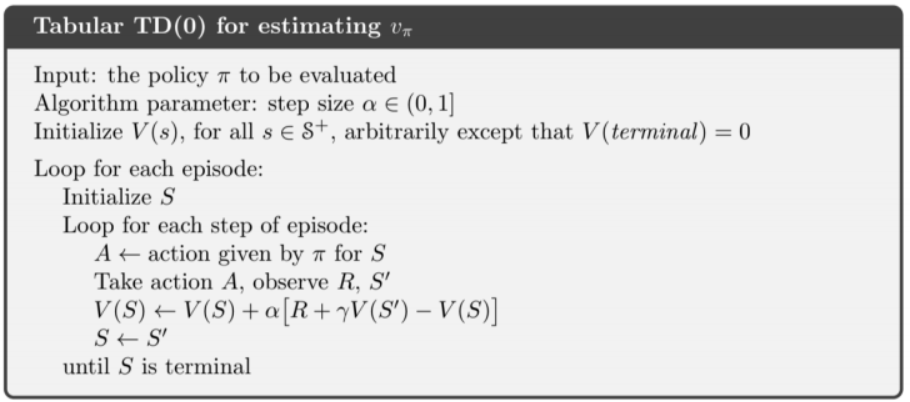

In [4]:
def td_value_prediction(env, policy):
    gamma = 0.9
    alpha = 5e-3

    value_vector = np.zeros([len(env.state_space)])

    # Repeat policy 
    for loop_count in range(10000):
        done = False
        step_count = 0
        s = env.reset()

        # Generate an episode
        while (not done):
            i_s = env.get_state_index(env.state_space, s)
            pi_s = policy[i_s]
            a = np.random.choice(env.action_space, p = pi_s)
            r, s_next, done = env.step(a)

            i_s_next = env.get_state_index(env.state_space, s_next)
            td = r + gamma * value_vector[i_s_next]
            value_vector[i_s] += alpha * (td - value_vector[i_s])

            if done:
                value_vector[i_s_next] = 0

            step_count += 1
            s = s_next

        if (loop_count % 100 == 0):
            print(f"{loop_count} value vector : \n{value_vector.reshape(4, 4)}")

    return value_vector

In [5]:
env = GridWorld()
policy = []
for i_s, s in enumerate(env.state_space):
    pi = np.array([0.25, 0.25, 0.25, 0.25])
    policy.append(pi)
policy = np.array(policy)

value_vector = td_value_prediction(env, policy).reshape(4, 4)

0 value vector : 
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.05]
 [0.   0.   0.   0.  ]]
100 value vector : 
[[7.68980970e-04 3.01400162e-03 1.12709592e-02 2.97221482e-02]
 [3.06111424e-03 1.58084183e-02 6.95528590e-02 2.18800927e-01]
 [1.19541829e-02 8.68655185e-02 4.50744522e-01 1.76233215e+00]
 [2.83687230e-02 2.40303859e-01 1.84121562e+00 0.00000000e+00]]
200 value vector : 
[[0.01389219 0.03042257 0.06526959 0.1213578 ]
 [0.03084489 0.09107969 0.26856791 0.62295599]
 [0.07183809 0.28094532 0.95788143 2.97248362]
 [0.12913347 0.59110197 2.74729935 0.        ]]
300 value vector : 
[[0.04804544 0.08570742 0.17920294 0.2442115 ]
 [0.09273831 0.21507548 0.51763114 0.87857574]
 [0.170261   0.50965137 1.60347715 3.42234426]
 [0.24833635 0.90015871 3.6272517  0.        ]]
400 value vector : 
[[0.11118051 0.18424254 0.31509556 0.41797234]
 [0.17443284 0.34976057 0.71806176 1.21069531]
 [0.32112507 0.74157732 1.97276611 3.69616211]
 [0.42975513 1.27513707 3.80461923 0.

In [6]:
value_vector

array([[0.72494657, 0.86340651, 1.11179219, 1.3430199 ],
       [0.87274811, 1.13216019, 1.60470389, 2.24539602],
       [1.15243313, 1.65409064, 2.79795201, 4.667745  ],
       [1.4390387 , 2.34869846, 4.79886947, 0.        ]])